In [1]:
!pip3 install catboost

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
! pip install -U pymorphy2-dicts-ru
! pip install pymorphy2
! pip install pymorphy2-dicts

     |████████████████████████████████| 8.2 MB 785 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 55 kB 673 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.1 MB 775 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
#import keras
from keras import optimizers
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Модули для предобработки текста
import pymorphy2
import nltk
from nltk.corpus import stopwords

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


# Функции

In [6]:
# Метрика
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Функция для лемматизации текста
def lemma(text):
    pattern = "[^А-я ]+" 
    text = text.lower()  
    text = re.sub(pattern, ' ', text)  
    strings = []  
    for wrd in text.split():  
        wrd = wrd.strip()  
        wrd = morphy.normal_forms(wrd)[0] 
        strings.append(wrd)  

    return ' '.join(strings)  

# Функция для замены значений в столбце engineDisplacement
def form_Disp(x):
    if x == 'undefined LTR':
        x = '2.0 LTR'
    return x

# Функция для удаления стопслов
def lineWithoutStopWords(line):
    line = line.split()  # разделяем на слова
    # возвращаем слово, если оно не в списке стоп-слов
    return [word for word in line if word not in russian_stopwords]

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [11]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [12]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

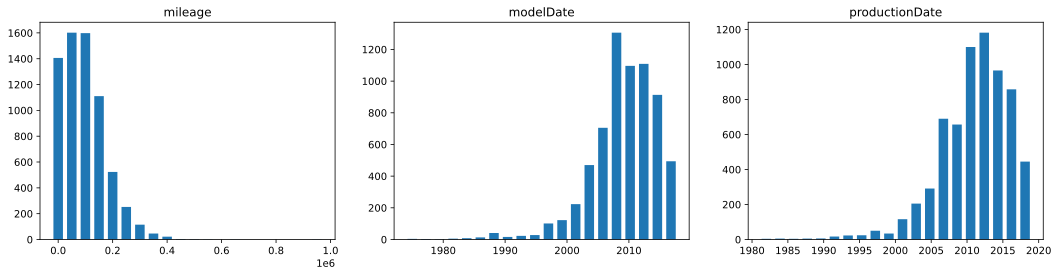

In [13]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [14]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

df = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, df.shape)

(6682, 23) (1671, 23) (8353, 23)


In [15]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    #используем все текстовые признаки как категориальные без предобработки
    categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_info', 'name','numberOfDoors', 
                            'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль','enginePower']

    #используем все числовые признаки
    numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower_', 'enginePower_/mileage']
    
    
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
    
    # Feature Engineering
    # Создадим числовой признак из 'enginePower' но при этом оставим и категориальный.
    df_output['enginePower_'] = df_output['enginePower'].str.split(' ').str[0]
    df_output['enginePower_'] = df_output['enginePower_'].astype(int)
    df_output['enginePower_/mileage'] = df_output['enginePower_']/df_output['mileage']
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].mean(), inplace=True)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
         
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей

    # Логарифмируем чиловые признаки
    df_output[numerical_features] = np.log(df_output[numerical_features])

    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [16]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(df)
df_preproc.sample(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


,mileage,modelDate,productionDate,sample,price,enginePower_,enginePower_/mileage,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,...,enginePower_610 N12,enginePower_612 N12,enginePower_625 N12,enginePower_626 N12,enginePower_639 N12,enginePower_700 N12,enginePower_75 N12,enginePower_82 N12,enginePower_95 N12,enginePower_98 N12
7399,-2.234935,-0.110001,-0.141079,1,1590000.0,-1.301953,-12.041180,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4273,-3.101114,-0.133531,-0.111226,1,3100000.0,-1.301953,-11.141892,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3362,-2.900439,-0.133531,-0.141079,1,3750000.0,-0.203341,-10.460733,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2794,-2.079449,-0.182322,-0.270290,1,1990000.0,-1.301953,-12.206490,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5378,-1.903815,-0.133531,-0.141079,1,1285000.0,-1.474907,-12.522449,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 1545 entries, mileage to enginePower_98 N12
dtypes: float64(6), int64(1), uint8(1538)
memory usage: 12.7 MB


## Split data

In [18]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

#y = np.log(train_data.price.values) # наш таргет
y = train_data.price.values
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 1544 entries, mileage to enginePower_98 N12
dtypes: float64(6), uint8(1538)
memory usage: 2.5 MB


# Model 2: CatBoostRegressor

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [21]:
model_cat = CatBoostRegressor(iterations = 20000,
                          learning_rate = 0.01,
                          l2_leaf_reg=2,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',

                         )
model_cat.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=1000,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0423278	test: 0.0423973	best: 0.0423973 (0)	total: 57.9ms	remaining: 19m 17s
1000:	learn: 0.0093922	test: 0.0095045	best: 0.0095045 (1000)	total: 6.01s	remaining: 1m 54s
2000:	learn: 0.0082596	test: 0.0086229	best: 0.0086229 (2000)	total: 12.2s	remaining: 1m 49s
3000:	learn: 0.0076972	test: 0.0082462	best: 0.0082460 (2998)	total: 18.7s	remaining: 1m 45s
4000:	learn: 0.0072731	test: 0.0080242	best: 0.0080240 (3996)	total: 24.8s	remaining: 1m 39s
5000:	learn: 0.0069312	test: 0.0078842	best: 0.0078841 (4998)	total: 31s	remaining: 1m 32s
6000:	learn: 0.0066729	test: 0.0077965	best: 0.0077965 (6000)	total: 36.9s	remaining: 1m 26s
7000:	learn: 0.0064614	test: 0.0077341	best: 0.0077341 (6998)	total: 43.1s	remaining: 1m 20s
8000:	learn: 0.0062498	test: 0.0076856	best: 0.0076856 (7999)	total: 49s	remaining: 1m 13s
9000:	learn: 0.0060638	test: 0.0076654	best: 0.0076649 (8967)	total: 55.9s	remaining: 1m 8s
10000:	learn: 0.0058953	test: 0.0076527	best: 0.0076519 (9986)	total: 1m 2s	rem

In [22]:
test_predict_catboost = model_cat.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 11.03%


### Submission

In [23]:
sub_predict_catboost = model_cat.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_catboost)
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

## Simple Dense NN

In [24]:
df_NN = df.copy()

In [25]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    # Список категориальных признаков.
    categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_info',
                            'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 
                            'Руль','enginePower','4WD','xDrive']

    # Список числовых признаков.
    numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower_','enginePower_/mileage','mile_year' ]
    
    
    df_output = df_input.copy()
    
    # убираем не нужные для модели признаки.
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
    # Feature Engineering.
    
    # Приведение Владение к более стандартному виду.
    df_output['Владение'] = df_output['Владение'].str.extract(r'(\d{1,2})')
    
    # Заменяем значение undefined LTR на моду 2.0 LTR.
    df_output.engineDisplacement = df_output.engineDisplacement.apply(form_Disp)
    
    # Из признака name выводим 4WD в отдельный признак.
    df_output['4WD'] = df_output['name'].str.extract(r'(4WD)')
    df_output['4WD'] = df_output['4WD'].fillna('2WD')
    
    # Из признака name выводим xDrive в отдельный признак.
    df_output['xDrive'] = df_output['name'].str.extract(r'(xDrive)')
    df_output['xDrive'] = df_output['xDrive'].fillna('non_xDrive')
    
    # Создадим признак километраж в год.
    df_output['mile_year'] = df_output['mileage'] / (2022 - df_NN.modelDate)
    
    
    # Создадим числовой признак из 'enginePower' но при этом оставим и категориальный.
    df_output['enginePower_'] = df_output['enginePower'].str.split(' ').str[0]
    df_output['enginePower_'] = df_output['enginePower_'].astype(int)
    df_output['enginePower_/mileage'] = df_output['enginePower_']/df_output['mileage']
    
    
    
    # Далее заполняем пропуски.
    for column in numerical_features:
        df_output[column].fillna(df_output[column].mean(), inplace=True)
    
    # Используем RobustScaler так как он устойчив к выбросам
    scaler = RobustScaler() 
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]


    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)

    # Убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration','name'], axis = 1, inplace=True)
    
    return df_output

In [26]:
df_NN = preproc_data(df_NN)

In [27]:
# Теперь выделим тестовую часть
train_data = df_NN.query('sample == 1').drop(['sample'], axis=1)
test_data = df_NN.query('sample == 0').drop(['sample'], axis=1)

#y = np.log(train_data.price.values) # наш таргет
y = (train_data.price.values)
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [29]:
model_NN = Sequential()
model_NN.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_NN.add(L.Dropout(0.5))
model_NN.add(L.Dense(256, activation="relu"))
model_NN.add(L.Dropout(0.25))
model_NN.add(L.Dense(1, activation="linear"))

In [30]:
# Compile model
optimizer = tf.keras.optimizers.RMSprop(0.01)
model_NN.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [31]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [32]:
history = model_NN.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

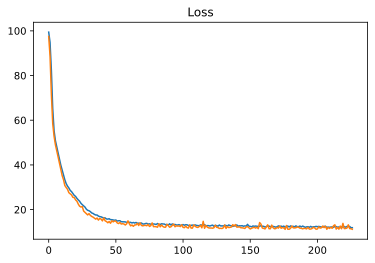

In [33]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [34]:
#model_NN.load_weights('../working/best_model.hdf5')
model_NN.save('../working/nn_1.hdf5')

In [35]:
test_predict_nn1 = model_NN.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.17%


In [36]:
sub_predict_nn1 = model_NN.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

# Lemmatize

In [37]:
df_NLP = df.copy()

In [38]:
morphy = pymorphy2.MorphAnalyzer()

In [39]:
# Применяем функцию лемматизации.
strings_set = []
strings_set = df_NLP.apply(lambda df_NLP: lemma(df_NLP.description), axis=1)

In [40]:
# Скачиваем стоп слова для русского языка и создаем переменную для них.
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [41]:
# Применим функцию для удаления стопслов к лемматизированым строкам.
str_without_stop = [lineWithoutStopWords(line) for line in strings_set]

In [42]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256



In [43]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(str_without_stop)

CPU times: user 461 ms, sys: 11.9 ms, total: 472 ms
Wall time: 472 ms


In [ ]:
tokenize.word_counts 

In [45]:
# После осмотра получившихся токенов добавляем следующие.
word_for_del = [ 'подъ', 'привет', 'кат','ма', 'би', 'акб','сный', 'ф', 'млн',  'мм', 'июнь', 'напп','лс', 'чип',
                'зд', 'ст', 'авар','оф', 'ещ', 'ти',  'ра', 'партн','ин', 'осаго', 'кпп', 'х', 'акпп', 'кол','который',
                'также',  'тыс', 'р','руб',  'код', 'мочь', 'свой','л', 'это', 'наш', 'м', 'весь', 'ваш', 'год', 'всё',
                'км','г','ч','рный','вс','прод','н','тся','ао','й','доп','б','эл','гк', 'п' ,'тд', 'двс' ,'ещё', 'мб', 'сч', 'ог', 'пд', 'са', 'пл', 'грм', 
                'лкп' ,'рег', 'зорг', 'жена', 'зерк', 'многий', 'юр', 'объ' ,'нпб', 'мимо', 'диз', 'вкл', 'нары', 'тр', 
                'ода', 'амг','гнелла','ный', 'зел','ка', 'ран','пр','ум', 'пб','кп','акп','др','ап','ватс']


# Добавление субьективных токенов
for i in word_for_del:
    if i not in russian_stopwords:
        russian_stopwords.append(i)

In [46]:
# Применим функцию для удаления стопслов к лемматизированым строкам.
str_without_stop = [lineWithoutStopWords(line) for line in strings_set]

In [47]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(str_without_stop)

CPU times: user 507 ms, sys: 6.55 ms, total: 514 ms
Wall time: 535 ms


In [48]:
# split данных
text_train = df.description.iloc[X_train.index]
text_test = df.description.iloc[X_test.index]
text_sub = df.description.iloc[X_sub.index]

In [49]:
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)


In [50]:
# вот так теперь выглядит наш текст
print(text_train.iloc[7])
print(text_train_sequences[7])

*обязательное предложение по трейд-ин
*предложения по кредиту

Автомобиль из собственного парка компании АВТОДОМ - первого официального дилерского центра BMW в России. Автомобиль проходит по программе BMW Premium Selection 12 месяцев или 25 000 км бесплатного ремонта * Приобретая автомобиль в нашем Дилерском центре, Вы получаете гарантию юридической чистоты автомобиля. Мы предложим Вам широкий выбор кредитных/лизинговых программ. В зачет стоимости этого автомобиля, Вы сможете сдать ваш текущий автомобиль и получить за это дополнительную выгоду.
*Обязательно предложение по Trade  in
*Обязательно предложение по кредиту

Мы находимся по адресу: Москва,  Шмитовский проспект 24А

Увеличенный объем бензобака
Программа Efficient Dynamics
Без спортивной настройки подвески
19" M легкосплавные диски Double-spoke 698 M
Обогрев рулевого колеса
Безопасные шины Runflat
Автоматическая коробка передач Steptronic с подрулевыми переключателями
Индикатор давления в шинах
Система Performance Control
Адапт

### RNN NLP

In [51]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [52]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.25))
model_mlp.add(L.Dense(64))


### Multiple Inputs NN

In [53]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model_mult_input = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

### Fit

In [54]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model_mult_input.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [55]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=30, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [56]:
history = model_mult_input.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 3s 259ms/step - loss: 99.9921 - MAPE: 99.9921 - val_loss: 99.9528 - val_MAPE: 99.9528
Epoch 2/500
12/12 [==============================] - 3s 208ms/step - loss: 99.8540 - MAPE: 99.8540 - val_loss: 99.5561 - val_MAPE: 99.5561
Epoch 3/500
12/12 [==============================] - 2s 207ms/step - loss: 99.3191 - MAPE: 99.3191 - val_loss: 98.7490 - val_MAPE: 98.7490
Epoch 4/500
12/12 [==============================] - 2s 202ms/step - loss: 98.3206 - MAPE: 98.3206 - val_loss: 97.3264 - val_MAPE: 97.3264
Epoch 5/500
12/12 [==============================] - 3s 210ms/step - loss: 96.4513 - MAPE: 96.4513 - val_loss: 94.6167 - val_MAPE: 94.6167
Epoch 6/500
12/12 [==============================] - 3s 209ms/step - loss: 92.9408 - MAPE: 92.9408 - val_loss: 89.6895 - val_MAPE: 89.6895
Epoch 7/500
12/12 [==============================] - 3s 218ms/step - loss: 86.9571 - MAPE: 86.9571 - val_loss: 81.6471 - val_MAPE: 81.6471
Epoch 8/500
12/12 [========

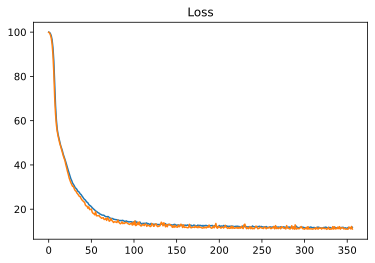

In [57]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [58]:
#model_mult_input.load_weights('../working/best_model.hdf5')
model_mult_input.save('../working/nn_mlp_nlp.hdf5')

In [59]:
test_predict_nn2 = model_mult_input.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 10.92%


In [60]:
sub_predict_nn2 = model_mult_input.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Blending без картинок

In [94]:
blend_predict =  (test_predict_nn2[:,0] + test_predict_nn1[:,0] + np.exp(test_predict_catboost)) // 3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.47%


In [62]:
blend_sub = (sub_predict_nn2 + sub_predict_nn1 + np.exp(sub_predict_catboost).reshape(1671,1))/3
sample_submission['price'] = blend_sub
sample_submission.to_csv('sub_blend_predict_non_img.csv', index=False)

# Model 5: Добавляем картинки

### Data

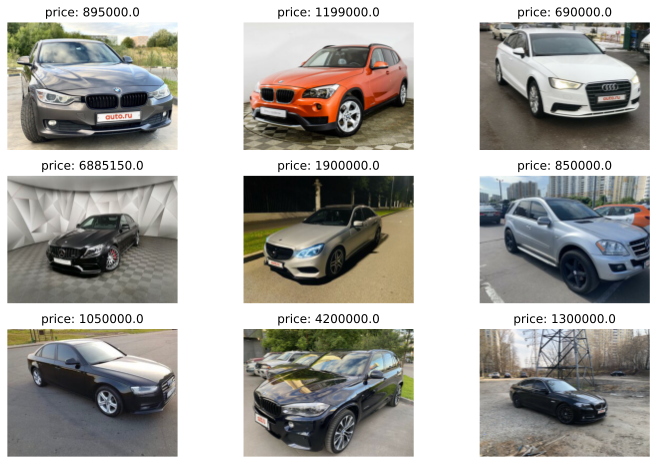

In [63]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [64]:
size = (320, 320)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(df['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)


In [65]:
images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 320, 320, 3) dtype uint8
images shape (1003, 320, 320, 3) dtype uint8
images shape (1671, 320, 320, 3) dtype uint8


### albumentations

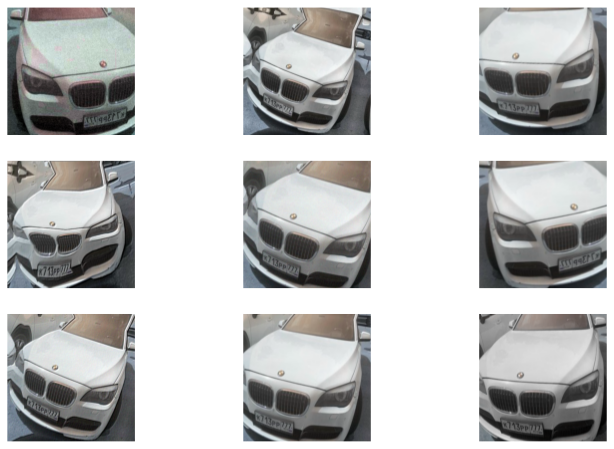

In [66]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [67]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [68]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(str_without_stop)

In [69]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, df.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, df.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, df.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [70]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [71]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.25),
    ])



In [72]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64, activation="relu"),
    L.Dropout(0.25),
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

In [74]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [75]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [76]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 160s 843ms/step - loss: 86.4740 - MAPE: 86.4740 - val_loss: 53.9187 - val_MAPE: 53.9187
Epoch 2/100
190/190 [==============================] - 156s 821ms/step - loss: 46.2787 - MAPE: 46.2787 - val_loss: 39.0661 - val_MAPE: 39.0661
Epoch 3/100
190/190 [==============================] - 155s 818ms/step - loss: 35.0028 - MAPE: 35.0028 - val_loss: 29.5441 - val_MAPE: 29.5441
Epoch 4/100
190/190 [==============================] - 156s 822ms/step - loss: 29.0207 - MAPE: 29.0207 - val_loss: 25.6635 - val_MAPE: 25.6635
Epoch 5/100
190/190 [==============================] - 156s 822ms/step - loss: 25.9454 - MAPE: 25.9454 - val_loss: 22.8290 - val_MAPE: 22.8290
Epoch 6/100
190/190 [==============================] - 156s 820ms/step - loss: 23.4458 - MAPE: 23.4458 - val_loss: 20.3313 - val_MAPE: 20.3313
Epoch 7/100
190/190 [==============================] - 156s 820ms/step - loss: 21.4534 - MAPE: 21.4534 - val_loss: 18.4840 - val_MAPE: 18.4840

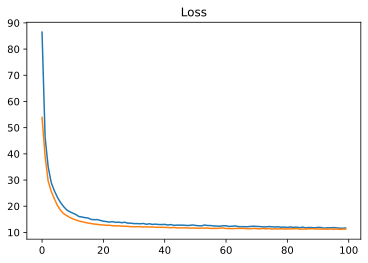

In [77]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [78]:
#model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [79]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.27%


In [80]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blending

In [89]:
# CV + Cat
blend_predict_cv = ( np.exp(test_predict_catboost) + test_predict_nn3[:,0]) // 2
print(f"TEST mape: {(mape(y_test, blend_predict_cv))*100:0.2f}%")


TEST mape: 10.45%


In [90]:
# NLP + NN + Cat
blend_predict_non_cv = (test_predict_nn2[:,0] + test_predict_nn3[:,0] + np.exp(test_predict_catboost))  // 3
print(f"TEST mape: {(mape(y_test, blend_predict_non_cv))*100:0.2f}%")


TEST mape: 10.43%


In [93]:
# NLP + NN + CV + Cat
blend_predict_all =  (test_predict_nn2[:,0] + test_predict_nn1[:,0] + np.exp(test_predict_catboost) + test_predict_nn3[:,0]) // 4
print(f"TEST mape: {(mape(y_test, blend_predict_all))*100:0.2f}%")


TEST mape: 10.55%


# SUB